# CTD: Fixed Depth Platforms

**Author: Andrew Reed**

### Purpose
The purpose of this notebook is to calculate the QARTOD test data tables for the CGSN-maintained CTD instruments on fixed-depth platforms, such as the surface moorings, near-surface-instrument-frames, and mooring risers.

### Method
The approach outlined here attempts to conform to the approach to outlined in the QARTOD Manual for In-situ Temperature and Salinity Observations [1] for implementing the _gross range_ and _climatology_ QARTOD tests on the CTDBP class of instruments (CTD - Bottom Pumped). 

**Data**

First, all of the data for a given reference designator that is available via the various methods (telemetered, recovered host, and recovered instrument) is identified and downloaded. The datasets are reprocessed to eliminate unnecessary variables and are then combined into a single dataset. The combined dataset is then resampled to every 3 hours using the median.

**Annotations**

Next, the annotations for the reference designator are downloaded. The annotations may have associated quality flags of _suspect_, _fail_, or _not available_. These flags are mapped to their QARTOD appropriate flags (3, 4, 9 respectively). These flags are added to the dataset and all data points with a flag of 4 are removed. Then, the data with flags of 3 are inspected and determined if they should be removed on a case-by-case basis.

**Gross Range Test**

The Gross Range test aims to identify data that fall outside either the sensor measurement range or is a statistical outlier. First, the failed/bad data threshold is based on the calibration range for a given sensor for the measured parameter. Next, we test the data to determine if it is normally distributed. If it is, we calculate the "user range" threshold for interesting/suspect data as the mean ± 3 standard deviations based on the historical OOI data for the variable at a deployed location. If the data is not normally distributed, we utilize the 0.15 and 99.85 percentiles of the data as the lower/upper thresholds for the user range.

Once the gross range thresholds are calculated, they are used to run the gross range test on the original downloaded data sets (before they are combined and resampled). The total number of points assessed, the number of failed points, and the number of "suspect/interesting" points are calculated and saved to a json object with a timestamp.

**Climatology Test**

The Climatology Test is a variation on the Gross Range Test, and is more appropriatelly described as a monthly-varying range test. This is done by modifying the relevant suspicious/interesting data thresholds for each calendar-month by accounting for seasonal cycles, which we calculate for a given variable using harmonic analysis. This approach is less susceptible to spurious values that can arise either from data gaps, measurement errors or from the presence of real, but anomalous, geophysical conditions in the available record.  First, we group the data by calendar-month (e.g. January, February, …, December) and calculate the average for each month. Then we fit the monthly-averaged-data with a two-cycle (annual plus semiannual) harmonic model. Each harmonic is determined using a least-squares fit to produce a “climatological” fit for each calendar-month.

Next, we calculate the standard deviation for each calendar-month from the grouped observations for the month. The thresholds for suspicious/interesting data are set as the climatological-fit ± 3 standard deviations. Occasionally, data gaps may mean that there are no historical observations for a given calendar-month. In these instances, we linearly interpolate the threshold from the nearest months. For sensors mounted on profiler moorings or vehicles, we first divide the data into subsets using standardized depth bins to account for differences in seasonality and variability at different depths in the water column.

Once the climatology thresholds are calculated, they are used to run the climatology test on the original downloaded data sets (before they are combined and resampled). The total number of points assessed and the number of "suspect/interesting" points are calculated and saved to a json object with a timestamp. 

### Test Parameters
We only test parameters and data streams of OOI data which contain _scientifically_ useful data. The following parameters and associated instrument ranges are given below:

| Instrument Class | Variable | Range | 
|------------------|----------|-------|
| CTDBPC | sea_water_temperature | -5 - 35 $^{\circ}$C |
|        | sea_water_practical_salinity | 0 - 42 psu |
|        | sea_water_pressure | 0 - 110 dbar |
| CTDBPD | sea_water_temperature | -5 - 35 $^{\circ}$C |
|        | sea_water_practical_salinity | 0 - 42 psu |
|        | sea_water_pressure | 0 - 350 dbar |
| CTDBPE | sea_water_temperature | -5 - 35 $^{\circ}$C |
|        | sea_water_practical_salinity | 0 - 42 psu |
|        | sea_water_pressure | 0 - 600 dbar |
| CTDBPF | sea_water_temperature | -5 - 35 $^{\circ}$C |
|        | sea_water_practical_salinity | 0 - 42 psu |
|        | sea_water_pressure | 0 - 110 dbar |
| CTDBPP | sea_water_temperature | -5 - 35 $^{\circ}$C |
|        | sea_water_practical_salinity | 0 - 42 psu |
|        | sea_water_pressure | 0 - 600 dbar |

### References
1. U.S. Integrated Ocean Observing System, 2015. Manual for Real-Time Quality Control of In-situ Temperature and Salinity Data Version 2.0: A Guide to Quality Control and Quality Assurance of In-situ Temperature and Salinity Observations. 56 pp.

#### Import libraries

In [1]:
import os, sys, datetime, pytz, re, io, ast
import dateutil.parser as parser

import pandas as pd
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import gc
import json
import matplotlib.pyplot as plt
%matplotlib inline

#### Import the ```ooinet``` M2M toolbox

In [2]:
from ooinet import M2M
from ooinet.utils import convert_time, ntp_seconds_to_datetime, unix_epoch_time

#### Import ```ooi_data_explorations``` toolbox

In [3]:
# Import shared analysis tools from the ooi-data-explorations repo
from ooi_data_explorations.common import get_annotations, get_vocabulary, load_gc_thredds, load_kdata, add_annotation_qc_flags
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.uncabled.process_ctdbp import ctdbp_datalogger, ctdbp_instrument
from ooi_data_explorations.qartod.qc_processing import identify_blocks, create_annotations, process_gross_range, \
    process_climatology, parse_qc, inputs, ANNO_HEADER, CLM_HEADER, GR_HEADER

# Import the QARTOD repo and tools
from ooi_data_explorations.qartod.gross_range import GrossRange
from ooi_data_explorations.qartod.plotting import *
from ooi_data_explorations.qartod.qc_processing import format_gross_range, format_climatology

#### Import ```ioos_qc``` QARTOD toolbox

In [4]:
from ioos_qc.qartod import gross_range_test, climatology_test, ClimatologyConfig

---
## Datasets
Identify all of the OOI-CGSN CTD datasets available on OOINet. Since this can be a slow process, we save the results of the query to a local directory. If all the datasets have previously been identified, then want to simply load the identified data streams from local memory:

In [5]:
# Try to load the CGSN DOSTA datasets
try:
    datasets = pd.read_csv("../data/CTDBP_datasets.csv")
# If they haven't been downloaded yet
except:
    print("Downloading Dataset list...")
    datasets = M2M.search_datasets(instrument="CTDBP", English_names=True)
    # Filter for the CGSN datasets - the array name with start with either CP, GA, GI, GP, or GS
    cgsn = datasets["array"].apply(lambda x: True if x.startswith(("CP","GA","GI","GP","GS")) else False)
    datasets = datasets[cgsn]
    # Save the datasets
    datasets.to_csv("../data/CTDBP_datasets.csv", index=False)

Separate out the CGSN datasets from the EA and RCA datasets:

In [6]:
cgsn = datasets["array"].apply(lambda x: True if x.startswith(("CP","GA","GI","GP","GS")) else False)
datasets = datasets[cgsn]

Remove the CTDs that are mounted on gliders and AUVs ("MOAS")

In [7]:
moas = datasets["array"].apply(lambda x: True if "MOAS" in x else False)
datasets = datasets[~moas]
datasets

,array,array_name,node,node_name,instrument,instrument_name,refdes,url,deployments
0,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GS01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4]"
1,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GS01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4]"
2,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP031,CTD (40 meters),GS01SUMO-RII11-02-CTDBPP031,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4]"
3,GS01SUMO,Global Southern Ocean Apex Surface Mooring,RID16,Near Surface Instrument Frame,03-CTDBPF000,CTD,GS01SUMO-RID16-03-CTDBPF000,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4]"
4,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GI01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8, 9]"
5,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GI01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8, 9]"
6,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP031,CTD (40 meters),GI01SUMO-RII11-02-CTDBPP031,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3, 4, 5, 6, 7, 8, 9]"
7,GI01SUMO,Global Irminger Sea Apex Surface Mooring,RID16,Near Surface Instrument Frame,03-CTDBPF000,CTD,GI01SUMO-RID16-03-CTDBPF000,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"
8,GA01SUMO,Global Argentine Basin Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP033,CTD (130 meters),GA01SUMO-RII11-02-CTDBPP033,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3]"
9,GA01SUMO,Global Argentine Basin Apex Surface Mooring,RII11,Mooring Riser,02-CTDBPP032,CTD (80 meters),GA01SUMO-RII11-02-CTDBPP032,https://ooinet.oceanobservatories.org/api/m2m/...,"[2, 3]"


---
## Single Reference Designator
The reference designator acts as a key for an instrument located at a specific location. First, select a reference designator (refdes) to request data from OOINet.

In [8]:
reference_designators = sorted(datasets["refdes"])
print("Number of reference designators: " + str(len(reference_designators)))
for refdes in reference_designators:
    print(refdes)

Number of reference designators: 18
CP01CNSM-MFD37-03-CTDBPD000
CP01CNSM-RID27-03-CTDBPC000
CP03ISSM-MFD37-03-CTDBPD000
CP03ISSM-RID27-03-CTDBPC000
CP04OSSM-MFD37-03-CTDBPE000
CP04OSSM-RID27-03-CTDBPC000
GA01SUMO-RID16-03-CTDBPF000
GA01SUMO-RII11-02-CTDBPP031
GA01SUMO-RII11-02-CTDBPP032
GA01SUMO-RII11-02-CTDBPP033
GI01SUMO-RID16-03-CTDBPF000
GI01SUMO-RII11-02-CTDBPP031
GI01SUMO-RII11-02-CTDBPP032
GI01SUMO-RII11-02-CTDBPP033
GS01SUMO-RID16-03-CTDBPF000
GS01SUMO-RII11-02-CTDBPP031
GS01SUMO-RII11-02-CTDBPP032
GS01SUMO-RII11-02-CTDBPP033


Select a single reference designator (for development)

In [27]:
k=17
refdes = reference_designators[k]
print(refdes)

GS01SUMO-RII11-02-CTDBPP033


---
## Load Data
When calculating the QARTOD data tables, we only want to utilize the most complete data record available for a given reference designator. We can identify this by filtering for the largest value under ```count``` which indicates the number of particles in the system for a given dataset. The more particles, the more availabe data. While most of the time this will be the recovered_inst stream, in cases of instrument loss or failure, it may be the record recovered from the mooring host computer (recovered_host) or even data which was telemetered back to shore.

First, define a preprocessing function and wrapper to make opening the netCDF datasets easier. This preprocessing function trims the datasets so there are no overlapping time-indices. This allows multiple netCDF files to be opened as a single xarray dataset object while also not having to load the data into memory, significantly speeding up the data load.

In [28]:
# Get the datastreams
datastreams = M2M.get_datastreams(refdes)

# Filter out the "metadata" datastreams; use only the regular dataset
mask = datastreams["stream"].apply(lambda x: False if "metadata" in x or "blank" in x or "power" in x else True)
datastreams = datastreams[mask]
datastreams

,refdes,method,stream
0,GS01SUMO-RII11-02-CTDBPP033,recovered_host,ctdbp_p_dcl_instrument_recovered
1,GS01SUMO-RII11-02-CTDBPP033,recovered_inst,ctdbp_cdef_instrument_recovered
2,GS01SUMO-RII11-02-CTDBPP033,telemetered,ctdbp_p_dcl_instrument


In [29]:
# Load the data
site, node, sensor = refdes.split("-", 2)

# Initialize the data with None
tele_data = None
host_data = None
inst_data = None

# Now search the local data directory to get the data
for method in datastreams["method"].unique():
    stream = datastreams[datastreams["method"] == method]["stream"].iloc[0]
    if "tele" in method:
        print(f"Loading {method}-{stream} data...")
        tele_data = load_kdata(site, node, sensor, method, stream, tag=f'*{refdes}*.nc')
        tele_data = ctdbp_datalogger(tele_data)
        print("\n")
    elif "host" in method:
        print(f"Loading {method}-{stream} data...")
        host_data = load_kdata(site, node, sensor, method, stream, tag=f'*{refdes}*.nc')
        host_data = ctdbp_datalogger(host_data)
        print("\n")
    elif "inst" in method:
        print(f"Loading {method}-{stream} data...")
        inst_data = load_kdata(site, node, sensor, method, stream, tag=f'*{refdes}*.nc')
        inst_data = ctdbp_instrument(inst_data)
        print("\n")
    else:
        pass

Loading recovered_host-ctdbp_p_dcl_instrument_recovered data...


Loading and Processing Data Files: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]




Loading recovered_inst-ctdbp_cdef_instrument_recovered data...


Loading and Processing Data Files: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]




Loading telemetered-ctdbp_p_dcl_instrument data...


Loading and Processing Data Files: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


**Combine the datasets into a single dataset**

In [30]:
data = combine_datasets(tele_data, host_data, inst_data, 180)
data

<xarray.Dataset>
Dimensions:                                           (time: 3303)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/26)
    sea_water_pressure_qc_results                     (time) float64 29.0 ......
    sea_water_pressure                                (time) float64 134.0 .....
    sea_water_electrical_conductivity_qartod_results  (time) uint8 1 1 1 ... 1 1
    sea_water_pressure_qc_executed                    (time) float64 29.0 ......
    sea_water_practical_salinity_qc_executed          (time) uint8 29 29 ... 29
    sea_water_temperature_qartod_results              (time) uint8 1 1 1 ... 1 1
    ...                                                ...
    sea_water_pressure_qartod_results                 (time) uint8 1 1 1 ... 1 2
    sea_water_electrical_conductivity                 (time) float64 3.345 .....
    raw_seawater_conductivity                         (time) float64 1.365e+0...
    raw_seawater_temperature                          (time) float64 4.716e+0...
    raw_pressure_temperature                          (time) float64 3.228e+0...
    raw_seawater_pressure                             (time) float64 5.906e+0...
Attributes: (12/69)
    node:                               RII11
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_p_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                -54.40408
    lon:                                -89.20691

---
## Process the CTDBP

#### Annotations
The annotations associated with a specific reference designator may contain relevant information on the performance or reliability of the data for a given dataset. The annotations are downloaded from OOINet as a json and processed into a pandas dataframe. Each annotation may apply to the entire dataset, to a specific stream, or to a specific variable. With the downloaed annotations, we can use the information contained in the ```qcFlag``` column to translate the annotations into QC flags, which can then be used to filter out bad data. 

In [31]:
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
annotations

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,144,GS01SUMO,RII11,02-CTDBPP033,None,None,1462536000000,1481529480000,Deployment 2: Instrument failed.,False,lgarzio@marine.rutgers.edu,not_operational,[],2016-05-06T12:00:00,2016-12-12T07:58:00
1,412,GS01SUMO,RII11,02-CTDBPP033,None,None,1450124400000,1462536000000,Deployment 2: Recovered-instrument and telemet...,False,lgarzio@marine.rutgers.edu,suspect,[],2015-12-14T20:20:00,2016-05-06T12:00:00
2,834,GS01SUMO,None,None,None,None,1512777600000,1544330520000,Deployment 3: *UPDATED 2020-04-28: This moorin...,False,lgarzio@marine.rutgers.edu,None,[],2017-12-09T00:00:00,2018-12-09T04:42:00
3,1603,GS01SUMO,RII11,02-CTDBPP033,None,None,1547510400000,1579514460000,UPDATED 2020-04-14: The instrument was not rec...,False,cdobson@whoi.edu,None,[],2019-01-15T00:00:00,2020-01-20T10:01:00
4,2136,GS01SUMO,RII11,02-CTDBPP033,None,None,1499644800000,1544330520000,Deployment 3: The CTDBP03 is known to have sto...,False,cdobson@whoi.edu,not_operational,[],2017-07-10T00:00:00,2018-12-09T04:42:00
5,3605,GS01SUMO,RII11,02-CTDBPP033,None,None,1450124400000,1450128600000,Deployment 1: This instrument was not deployed...,False,swhite@whoi.edu,None,[],2015-12-14T20:20:00,2015-12-14T21:30:00


Pass in the annotations and the dataset to add the annotation ```qcFlag``` values to the dataset

In [39]:
data = add_annotation_qc_flags(data, annotations)
data

<xarray.Dataset>
Dimensions:                                           (time: 3303)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/27)
    sea_water_pressure_qc_results                     (time) float64 29.0 ......
    sea_water_pressure                                (time) float64 134.0 .....
    sea_water_electrical_conductivity_qartod_results  (time) float64 1.0 ... 1.0
    sea_water_pressure_qc_executed                    (time) float64 29.0 ......
    sea_water_practical_salinity_qc_executed          (time) float64 29.0 ......
    sea_water_temperature_qartod_results              (time) float64 1.0 ... 1.0
    ...                                                ...
    sea_water_electrical_conductivity                 (time) float64 3.345 .....
    raw_seawater_conductivity                         (time) float64 1.365e+0...
    raw_seawater_temperature                          (time) float64 4.716e+0...
    raw_pressure_temperature                          (time) float64 3.228e+0...
    raw_seawater_pressure                             (time) float64 5.906e+0...
    rollup_annotations_qc_results                     (time) float64 nan ... nan
Attributes: (12/69)
    node:                               RII11
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_p_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                -54.40408
    lon:                                -89.20691

Plot where the data points are flagged to determine if they should be filtered out

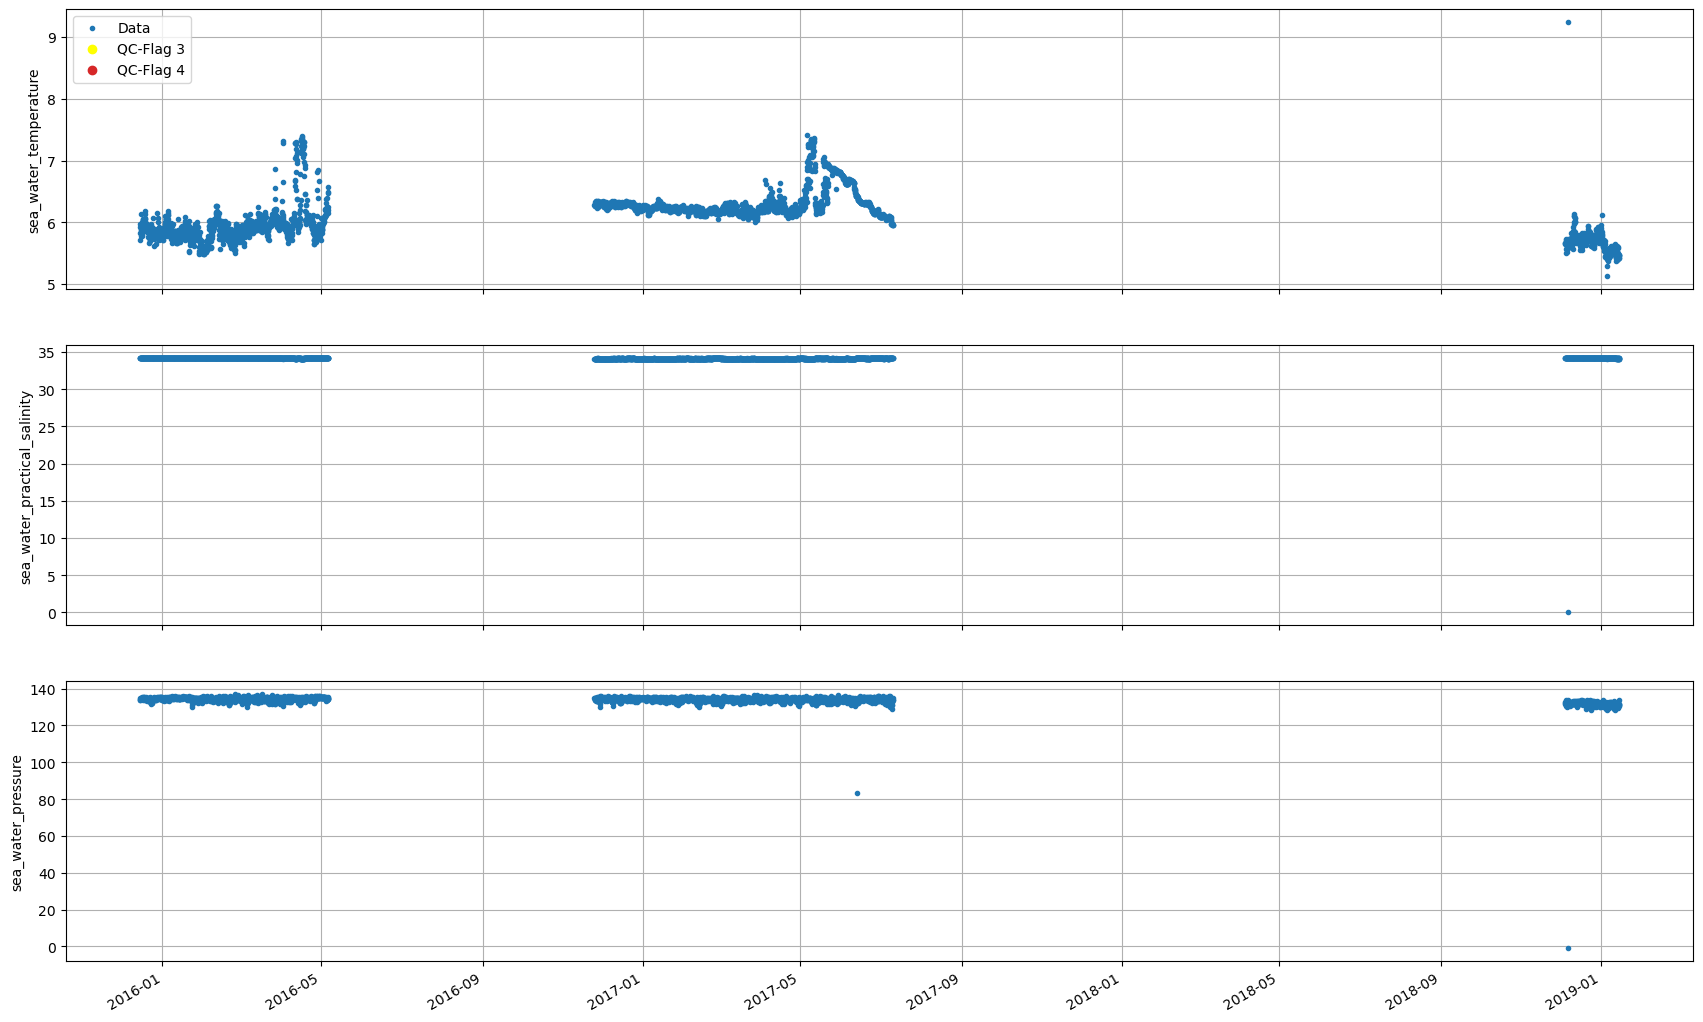

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols = 1, figsize=(21, 14))

param1="sea_water_temperature"
param2="sea_water_practical_salinity"
param3="sea_water_pressure"

qc3, = np.where(data.rollup_annotations_qc_results == 3)
qc4, = np.where(data.rollup_annotations_qc_results == 4)

ax1.plot(data.time, data[param1], marker=".", linestyle="", label="Data")
#ax1.plot(data_3hr.time, data_3hr[param1], marker=".", linestyle="", color="tab:red", label="3-hr median")
ax1.plot(data.time[qc3], data[param1][qc3], marker="o", linestyle="", color="yellow", label="QC-Flag 3")
ax1.plot(data.time[qc4], data[param1][qc4], marker="o", linestyle="", color="tab:red", label="QC-Flag 4")

ax1.legend()
ax1.grid()
ax1.set_ylabel(param1)

ax2.plot(data.time, data[param2], marker=".", linestyle="", label="Data")
#ax2.plot(data_3hr.time, data_3hr[param2], marker=".", linestyle="", color="tab:red", label="3-hr median")
ax2.plot(data.time[qc3], data[param2][qc3], marker="o", linestyle="", color="yellow", label="QC-Flag 3")
ax2.plot(data.time[qc4], data[param2][qc4], marker="o", linestyle="", color="tab:red", label="QC-Flag 4")
#ax2.set_ylim((34, 34.5))

ax2.grid()
ax2.set_ylabel(param2)


ax3.plot(data.time, data[param3], marker=".", linestyle="", label="Data")
#ax2.plot(data_3hr.time, data_3hr[param2], marker=".", linestyle="", color="tab:red", label="3-hr median")
ax3.plot(data.time[qc3], data[param3][qc3], marker="o", linestyle="", color="yellow", label="QC-Flag 3")
ax3.plot(data.time[qc4], data[param3][qc4], marker="o", linestyle="", color="tab:red", label="QC-Flag 4")
#ax2.set_ylim((34, 34.5))

ax3.grid()
ax3.set_ylabel(param3)

fig.autofmt_xdate()

Use the added ```rollup_annotations_qc_results``` values to filter out bad (```rollup_annotations_qc_results``` value of 4) data from the dataset

In [41]:
# clean-up the data, removing values that were marked as fail either from the quality checks or in the
# annotations, and all data collected after the cut off date
data = data.where((data.rollup_annotations_qc_results != 4))# & (data.rollup_annotations_qc_results != 3))

#### Limit the data to data collected before 2024-01-01

In [42]:
_, index = np.unique(data['time'], return_index=True)
data = data.isel(time=index)
data = data.sel(time=slice('2014-01-01T00:00:00', "2024-01-01T00:00:00"))

In [43]:
refdes

'GS01SUMO-RII11-02-CTDBPP033'

In [44]:
# If the cruise is CP04OSSM-MFD37-03-CTDBPE000, remove deployment 1
if refdes == 'CP04OSSM-MFD37-03-CTDBPE000':
    data = data.where(data.deployment != 1, drop=True)
if refdes == 'GI01SUMO-RII11-02-CTDBPP031':
    data = data.where((data['sea_water_pressure'] > 0) & (data['sea_water_practical_salinity'] > 34.2), drop=True)
if refdes == 'GI01SUMO-RII11-02-CTDBPP032':
    data = data.where((data['sea_water_pressure'] < 100) & (data['sea_water_practical_salinity'] > 34.5) & (data['sea_water_pressure'] > 0), drop=True)
if refdes == 'GI01SUMO-RII11-02-CTDBPP033':
    data = data.where((data['sea_water_pressure'] < 150) & (data['sea_water_practical_salinity'] > 34.79), drop=True)


---
## QARTOD Thresholds
The Gross Range QARTOD test consists of two parameters: a fail range which indicates when the data is bad, and a suspect range which indicates when data is either questionable or interesting. The fail range values are set based upon the instrument/measurement and associated calibration. For example, the conductivity sensors are calibration for measurements between 0 (freshwater) and 9 (highly-saline waters). The suspect range values are calculated based on the mean of the available data $\pm$3$\sigma$.

**Define functions**

In [45]:
def plot_gross_range(data, var, suspect_span, fail_span):
    """Plot the gross range values calculate from the data"""
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    # Get start and stop times
    tmin = data["time"].min()
    tmax = data["time"].max()
    
    ymed = data[var].mean()
    ystd = data[var].std()
    ymin = ymed - 5*ystd
    ymax = ymed + 5*ystd
    
    # Identify data which fall outside the suspect ranges
    qf3, = np.where((data[var] < suspect_span[0]) | (data[var] > suspect_span[1]))
    
    # Plot the data with the 
    ax.plot(data["time"], data[var], marker=".", linestyle = "", label="Data")
    ax.plot(data["time"][qf3], data[var][qf3], marker=".", linestyle="", color="yellow", label="Suspect")
    #ax.hlines(suspect_span, tmin, tmax, colors="tab:red")
    ax.fill_between(data["time"], suspect_span[0], suspect_span[1], color="tab:red", alpha=0.3, label="Suspect Span")
    
    # Set the different labels
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel(data[var].attrs["standard_name"])
    ax.grid()
    ax.legend()
    if "pressure" in var:
        ax.invert_yaxis()
    
    fig.autofmt_xdate()
    
    return fig, ax


def gross_range_statistics(datasets, gr_lookup):
    """Calculate the statistics for the gross range qartod test"""
    
    statistics = {}
    # Calculate statistics for the telemetered data
    for dset in datasets:
        if dset is None:
            continue
            
        stream = dset.stream
        
        statistics[stream] = {}
        
        # Find the associated parameters
        lookup = gr_lookup[gr_lookup["stream"] == stream]
        
        # Iterate through each parameter
        for index in lookup.index:
            
            # Get the input parameter
            inp = lookup.loc[index, 'parameter'].get('inp')
            
            # Check that the input is in the dataset, if not, search through
            # the data variables looking under "alternate_parameter_name"
            if inp in dset.variables:
                var = inp
            else:
                for var in dset.variables:
                    if 'alternate_parameter_name' in dset[var].attrs:
                         if inp == dset[var].attrs['alternate_parameter_name']:
                                break
            
            # Get the qcConfig object, the fail_span, and the suspect_span
            qcConfig = lookup.loc[index, 'qcConfig'].get('qartod')
            fail_span = qcConfig.get("gross_range_test").get("fail_span")
            suspect_span = qcConfig.get("gross_range_test").get("suspect_span")
            
            # Run the gross range test
            results = gross_range_test(
                inp = dset[var].fillna(999999).values,
                fail_span = fail_span,
                suspect_span = suspect_span)
            
            # Calculate the statistics
            total = len(results.data)
            suspect = len(results.data[results.data == 3])
            fail = len(results.data[results.data == 4])
            
            # Save the results
            statistics[stream][inp] = {
                'total': total,
                'suspect': suspect,
                'fail': fail}
            
    return statistics


def climatology_statistics(datasets, clm_lookup, clm_tables):
    """Calculate the statistics for the gross range qartod test"""
    
    statistics = {}
    # Calculate statistics for the telemetered data
    for dset in datasets:
        if dset is None:
            continue
            
        stream = dset.stream
        
        statistics[stream] = {}
        
        # Find the associated parameters
        lookup = clm_lookup[clm_lookup["stream"] == stream]
        
        # Iterate through each parameter
        for index in lookup.index:
            
            # Create a climatologyConfig object
            c = ClimatologyConfig()
            
            # Get the input parameter
            inp = lookup.loc[index, 'parameters'].get('inp')
            
            # Get the tinp
            tinp = lookup.loc[index, 'parameters'].get('tinp')
            
            # Get the zinp
            zinp = lookup.loc[index, 'parameters'].get('zinp')
            
            # Check that the 'zinp' is in the dataset. If not, need to add a dummy variable
            if zinp not in dset.variables:
                dset[zinp] = ([tinp], np.ones(dset[tinp].shape))
            
            # Get the climatology table
            if index > (len(clm_tables)-1):
                table = clm_tables[index % len(clm_tables)]
            else:
                table = clm_tables[index]
            
            # Check that the input is in the dataset, if not, search through
            # the data variables looking under "alternate_parameter_name"
            if inp in dset.variables:
                var = inp
            else:
                for var in dset.variables:
                    if 'alternate_parameter_name' in dset[var].attrs:
                         if inp == dset[var].attrs['alternate_parameter_name']:
                                break
            #
            clm = pd.read_csv(io.StringIO(table), index_col=0)
            clm = clm.applymap(ast.literal_eval)
            # Rename the columns to the months
            for col in clm.columns:
                clm.rename(columns={col: int(np.mean(ast.literal_eval(col)))}, inplace=True)
                
            # Iterate through the pressure ranges in the climatology table
            for p_range in clm.index:
                # Get the pressure range
                pmin, pmax = ast.literal_eval(p_range)

                # Convert the pressure range values into a dictionary
                p_values = clm.loc[p_range].to_dict()

                # Check the pressure values. If [0, 0], then set the range [0, 5000]
                if pmax == 0:
                    pmax = 5000

                for tspan in p_values.keys():
                    # Get the values associated with the time span
                    vmin, vmax = p_values.get(tspan)

                    # Add the test to the climatology config object
                    c.add(tspan=[tspan, tspan],
                          vspan=[vmin, vmax],
                          fspan=[fail_span[0], fail_span[1]],
                          zspan=[pmin, pmax],
                          period="month")
            # Run the climatology test
            results = climatology_test(c,
                                       inp=dset[var],
                                       tinp=dset[tinp],
                                       zinp=dset[zinp])
                       
            # To align with OOI practice, swap 4s for 3s
            results.data[results.data == 4] = 3
            
            # Calculate the statistics
            total = len(results.data)
            suspect = len(results.data[results.data == 3])
            
            # Save the results
            statistics[stream][inp] = {
                'total': total,
                'suspect': suspect}
            
    return statistics


def plot_climatology(ds, var, clm_table):
    """Plot the climatology on the data"""
    clm = pd.read_csv(io.StringIO(clm_table), index_col=0)
    clm = clm.applymap(ast.literal_eval)
    # Rename the columns to the months
    for col in clm.columns:
        clm.rename(columns={col: int(np.mean(ast.literal_eval(col)))}, inplace=True)
    
    # Generate the monthly time vector
    dstart = data["time"].resample(time="1M", label='left').count()["time"].values
    dend = data["time"].resample(time="1M", label='right').count()["time"].values
    monthly_avg = np.empty(dend.shape)
    monthly_min = np.empty(dend.shape)
    monthly_max = np.empty(dend.shape)
    for k, d in enumerate(dend):
        d = pd.to_datetime(d)
        monthly_avg[k] = np.mean(clm[d.month].values[0])
        monthly_min[k] = clm[d.month].values[0][0]
        monthly_max[k] = clm[d.month].values[0][1]

    
    # Calculate the climatology test
    # Initialize a climatology test
    c = ClimatologyConfig()

    # Iterate through the pressure ranges in the climatology table
    for p_range in clm.index:
        # Get the pressure range
        pmin, pmax = ast.literal_eval(p_range)

        # Convert the pressure range values into a dictionary
        p_values = clm.loc[p_range].to_dict()

        # Check the pressure values. If [0, 0], then set the range [0, 5000]
        if pmax == 0:
            pmax = 5000

        for tspan in p_values.keys():
            # Get the values associated with the time span
            vmin, vmax = p_values.get(tspan)

            # Add the test to the climatology config object
            c.add(tspan=[tspan, tspan],
                  vspan=[vmin, vmax],
                  fspan=[fail_span[0], fail_span[1]],
                  zspan=[pmin, pmax],
                  period="month")
    # Run the climatology test
    clm_results = climatology_test(c,
                                   inp=ds[var],
                                   tinp=ds["time"],
                                   zinp=ds["sea_water_pressure"])
    
    # ------------- PLOT THE DATA --------------
    fig, ax = plt.subplots(figsize=(15,10))
    
    # Plot the monthly averages
    ax.hlines(monthly_avg, dstart, dend, color="black")
    for n in np.arange(0, len(dend), 1):
        ax.fill_between([dstart[n], dend[n]], [monthly_min[n], monthly_min[n]], [monthly_max[n], monthly_max[n]], color="tab:red", alpha=0.3)

    # Plot the Observations
    ax.plot(ds.time, ds[var], marker=".", linestyle="", color="tab:blue", zorder=0, label="Observations")
    
    # Highlight the data marked as suspicious
    mask = (clm_results == 3)
    ax.plot(ds["time"][mask], ds[var][mask], marker=".", linestyle="", color="yellow", label="QC Flag 3")
    
    # Set the figure legends
    
    yavg, ystd = np.mean(ds[var]), np.std(ds[var])
    ymin, ymax = yavg-ystd*5, yavg+ystd*5
    ax.grid()
    ax.set_ylabel(var)
    ax.set_ylim((ymin, ymax))
    ax.legend()
    
    fig.autofmt_xdate()
    
    return fig, ax


def build_directories(names):
    """Builds out a directory structure"""
    try:
        iterator = iter(names)
    except TypeError as te:
        print(names, 'must be iterable')
        
    # Build the path
    path = None
    for k,n in enumerate(names):
        if path is None:
            path = names[k]
        else:
            path = os.path.join(path, names[k])
    
    # Make the directory
    path = os.path.abspath(path)
    if not os.path.exists(path):
        os.makedirs(path)
        
    return path

### Calculate **Gross Range**

Testing data for normality: sea_water_electrical_conductivity
[########################################] | 100% Completed | 2.88 sms
Testing data for normality: sea_water_temperature
[########################################] | 100% Completed | 3.18 sms
Testing data for normality: sea_water_pressure
[########################################] | 100% Completed | 2.76 sms
Testing data for normality: sea_water_practical_salinity
[########################################] | 100% Completed | 3.18 sms


{'ctdbp_p_dcl_instrument': {'conductivity': {'total': 8358,
   'suspect': 45,
   'fail': 0},
  'temp': {'total': 8358, 'suspect': 37, 'fail': 0},
  'pressure': {'total': 8358, 'suspect': 158, 'fail': 1},
  'practical_salinity': {'total': 8358, 'suspect': 68, 'fail': 0}},
 'ctdbp_p_dcl_instrument_recovered': {'conductivity': {'total': 8358,
   'suspect': 44,
   'fail': 0},
  'temp': {'total': 8358, 'suspect': 36, 'fail': 0},
  'pressure': {'total': 8358, 'suspect': 158, 'fail': 0},
  'practical_salinity': {'total': 8358, 'suspect': 67, 'fail': 0}},
 'ctdbp_cdef_instrument_recovered': {'ctdbp_seawater_conductivity': {'total': 8907,
   'suspect': 28,
   'fail': 0},
  'ctdbp_seawater_temperature': {'total': 8907, 'suspect': 26, 'fail': 0},
  'ctdbp_seawater_pressure': {'total': 8907, 'suspect': 158, 'fail': 0},
  'practical_salinity': {'total': 8907, 'suspect': 53, 'fail': 0}}}

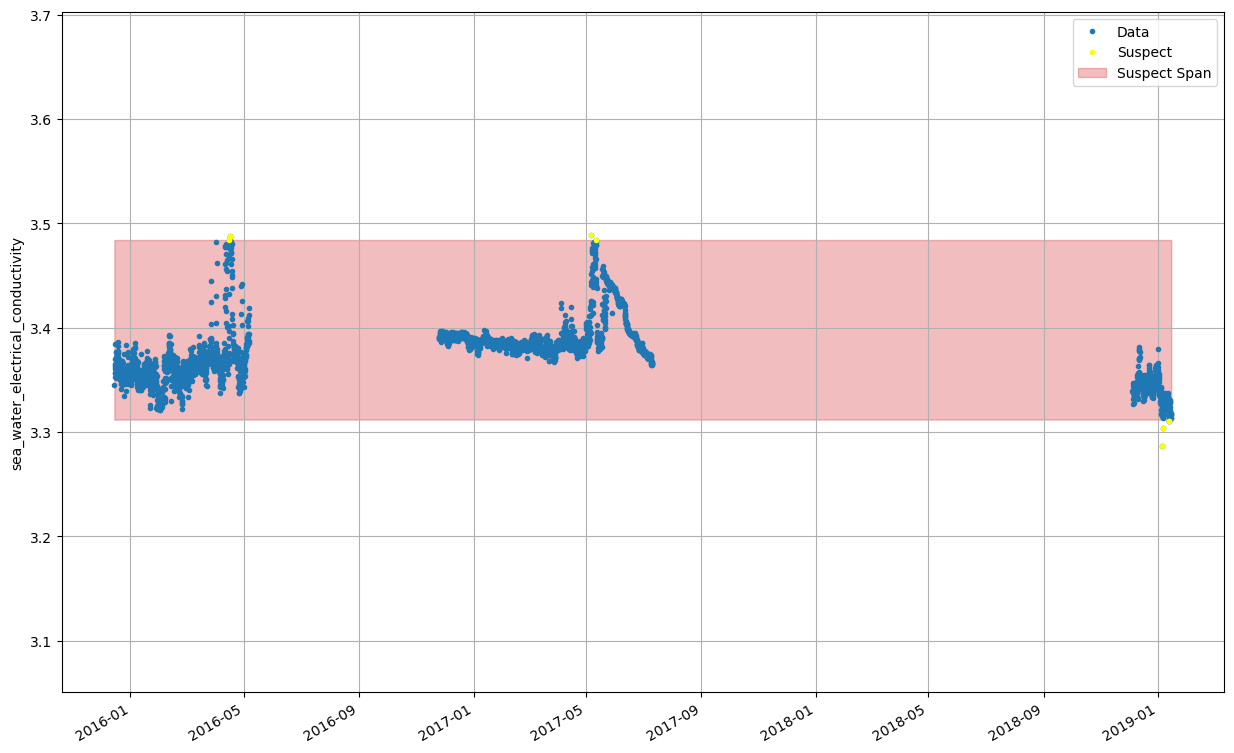

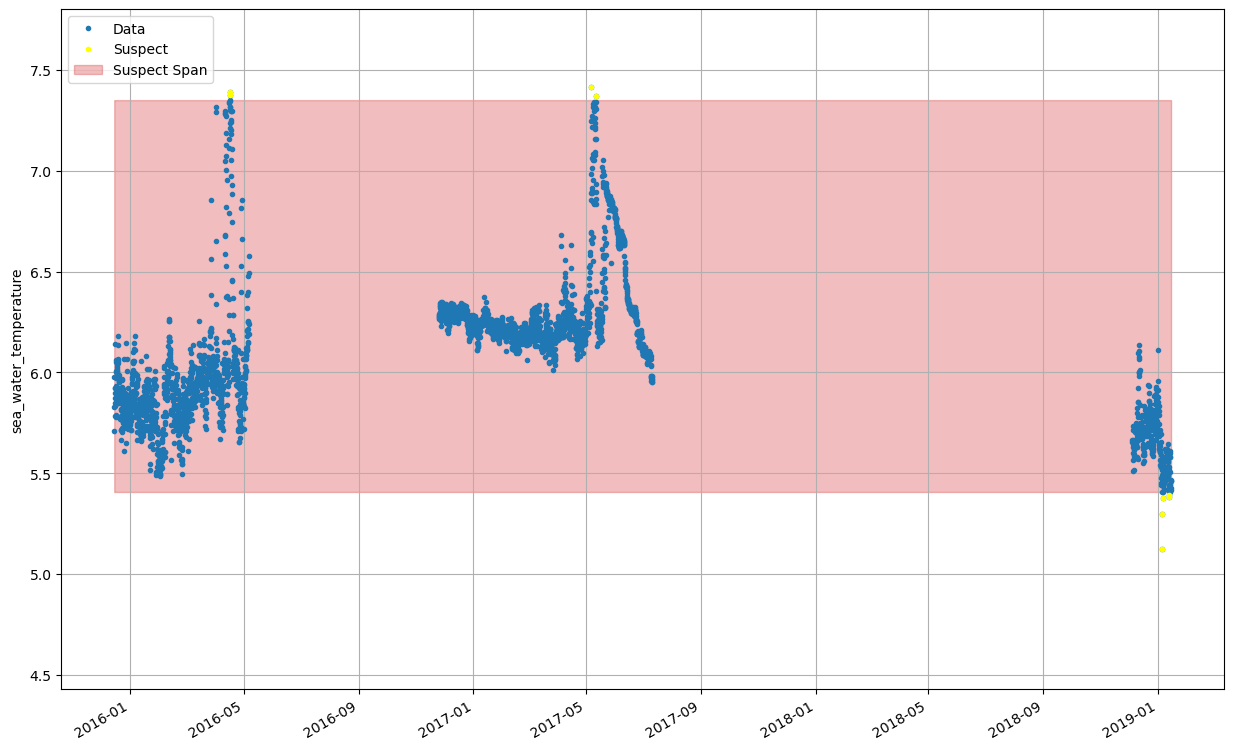

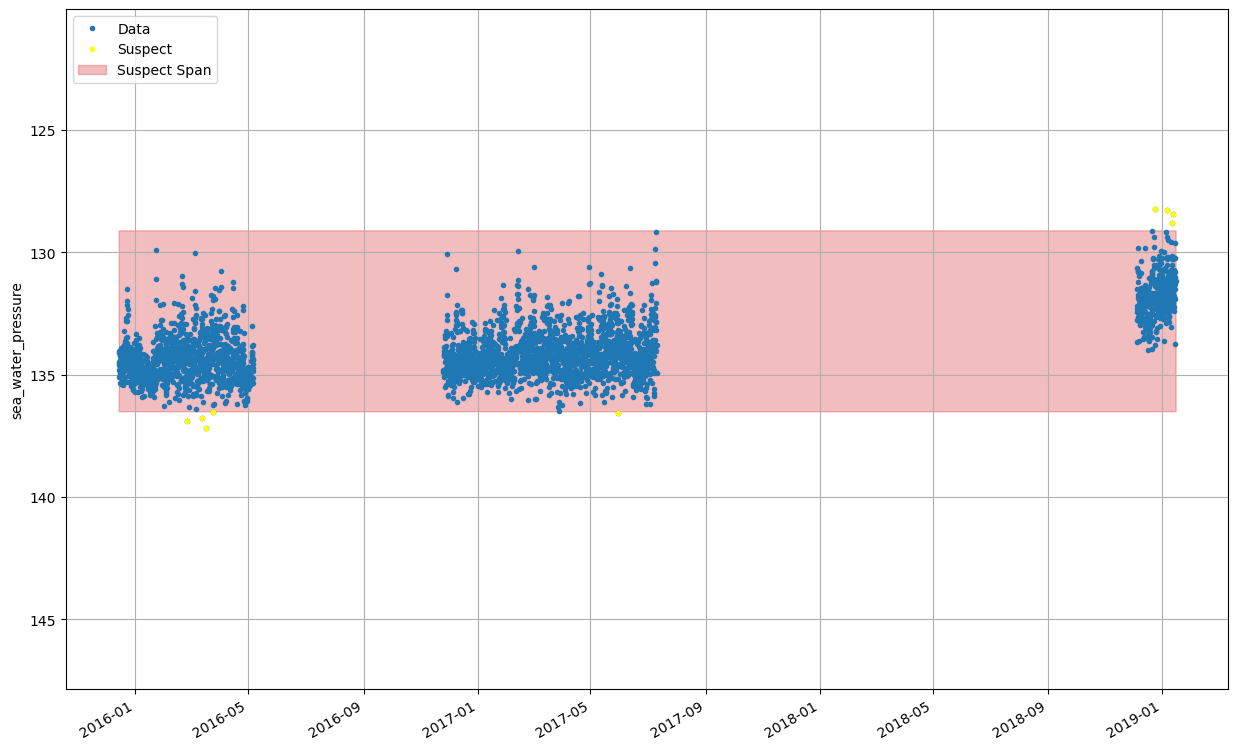

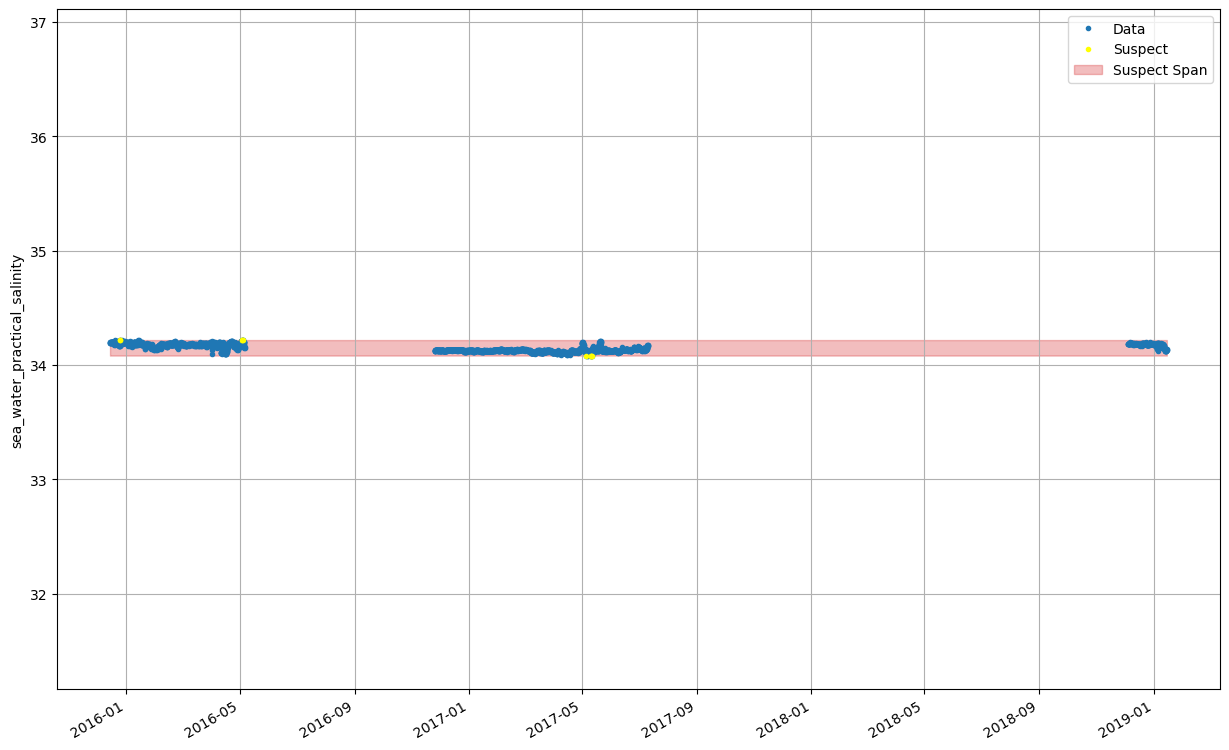

In [46]:
# set the parameters and the sensor range limits
test_parameters = ['sea_water_electrical_conductivity', 'sea_water_temperature', 'sea_water_pressure', 'sea_water_practical_salinity']

if "CTDBPC" in refdes or "CTDBPF" in refdes:
    plimit = [0, 110]
elif "CTDBPD" in refdes:
    plimit = [0, 350]
elif "CTDBPE" in refdes or "CTDBPP" in refdes:
    plimit = [0, 600]
else:
    plimit = [0, 5000]

limits = [[0, 9], [-5, 35], plimit, [0, 42]]

# create the initial gross range entry
gr_lookup = process_gross_range(data, test_parameters, limits, site=site, node=node, sensor=sensor)

gr_figs = {}
# Plot each of the variables
for index in gr_lookup.index:
    parameter = gr_lookup.loc[index, "parameter"].get("inp")
    qcConfig = gr_lookup.loc[index, "qcConfig"]
    suspect_span = qcConfig.get("qartod").get("gross_range_test").get("suspect_span")
    fail_span = qcConfig.get("qartod").get("gross_range_test").get("fail_span")
    # Plot
    fig, ax = plot_gross_range(data, parameter, suspect_span, fail_span)
    # Save the figures
    gr_figs[parameter] = (fig, ax)

# replicate it three times for the different streams
gr_lookup = pd.concat([gr_lookup] * 3, ignore_index=True)

# re-work the gross range entries for the different streams, resetting the variable names back to OOINet names
if 'CTDBPP' in refdes:
    streams = ['ctdbp_p_dcl_instrument', 'ctdbp_p_dcl_instrument_recovered', 'ctdbp_cdef_instrument_recovered']
else:
    streams = ['ctdbp_cdef_dcl_instrument', 'ctdbp_cdef_dcl_instrument_recovered', 'ctdbp_cdef_instrument_recovered']
variables = [
    ['conductivity', 'temp', 'pressure', 'practical_salinity'],
    ['conductivity', 'temp', 'pressure', 'practical_salinity'],
    ['ctdbp_seawater_conductivity', 'ctdbp_seawater_temperature', 'ctdbp_seawater_pressure', 'practical_salinity']
]
idx = 0
for num, stream in enumerate(streams):
    for j in range(4):
        gr_lookup['parameter'][idx + j] = {'inp': variables[num][j]}
        gr_lookup['stream'][idx + j] = stream
    idx += 4

# set the default source string
if refdes.startswith("CP01") or refdes.startswith("CP02") or refdes.startswith("CP03"):
    source = ('Sensor min/max based on the vendor sensor specifications. '
              'The user min/max is the historical mean of all data collected '
               '+/- 3 standard deviations.')
else:
    source = ('Sensor min/max based on the vendor sensor specifications. '
              'The user min/max is the historical mean of all data collected '
              'up to 2024-01-01 +/- 3 standard deviations.')
gr_lookup['source'] = source

# Calculate the gross_range_statistics
gr_stats = gross_range_statistics([tele_data, host_data, inst_data], gr_lookup)
gr_stats

#### Calculate **Climatology**

{'ctdbp_p_dcl_instrument': {'temp': {'total': 8358, 'suspect': 275},
  'practical_salinity': {'total': 8358, 'suspect': 317}},
 'ctdbp_p_dcl_instrument_recovered': {'temp': {'total': 8358, 'suspect': 274},
  'practical_salinity': {'total': 8358, 'suspect': 316}},
 'ctdbp_cdef_instrument_recovered': {'ctdbp_seawater_temperature': {'total': 8907,
   'suspect': 326},
  'practical_salinity': {'total': 8907, 'suspect': 364}}}

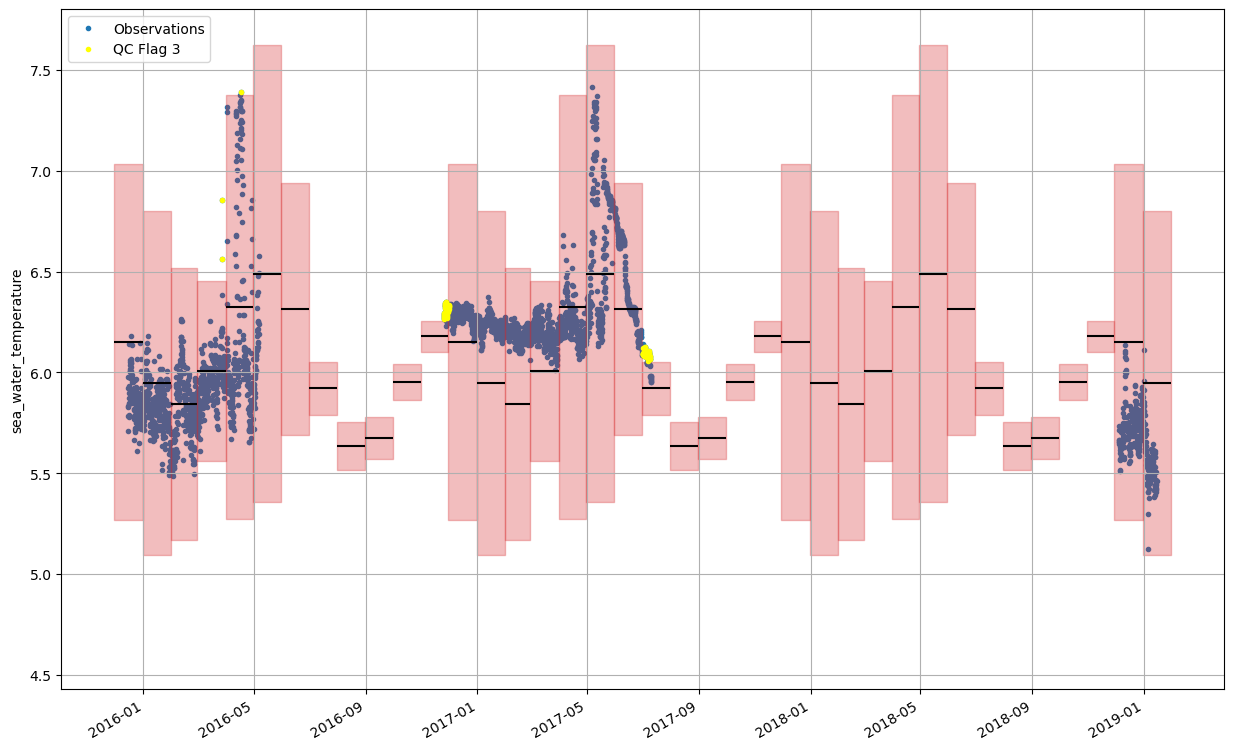

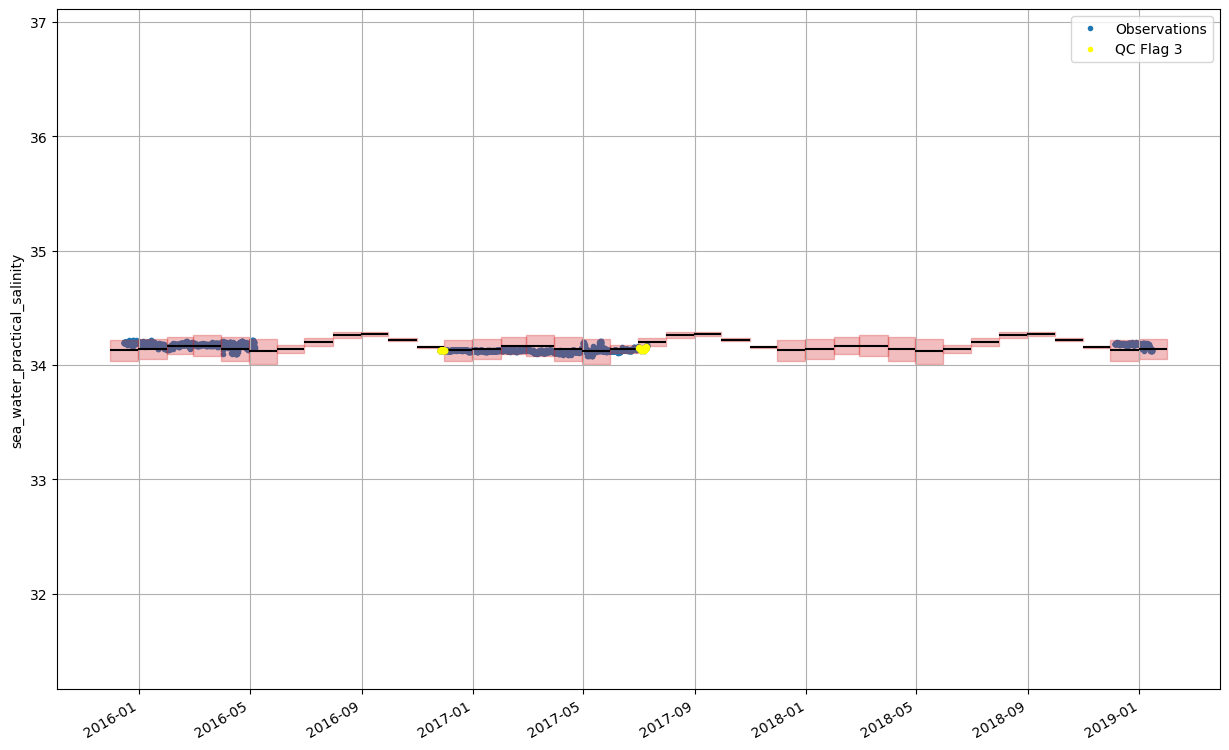

In [47]:
# create the initial climatology lookup and tables for the data
clm_lookup, clm_table = process_climatology(data, test_parameters[1:4:2], limits[1:4:2],
                                            site=site, node=node, sensor=sensor)

# Plot the climatology results
clm_figures = {}
for index in clm_lookup.index:
    parameter = clm_lookup.loc[index, "parameters"].get("inp")
    clm = clm_table[index]
    # Plot the figures
    fig, ax = plot_climatology(data, parameter, clm)
    clm_figures[parameter] = (fig, ax)
    
# replicate the climatology lookup table three times for the different streams
clm_lookup = pd.concat([clm_lookup] * 3, ignore_index=True)

# re-work the climatology lookup table for the different streams, resetting the variable names back to OOINet names
idx = 0
for num, stream in enumerate(streams):
    for j in [1, 3]:
        clm_lookup['parameters'][idx] = {'inp': variables[num][j], 'tinp': 'time', 'zinp': 'None'}
        clm_lookup['stream'][idx] = stream
        idx += 1
        
# Calculate the statistics
clm_stats = climatology_statistics([tele_data, host_data, inst_data], clm_lookup, clm_table)
clm_stats

In [48]:
for n in clm_lookup["notes"]:
    print(n)

The variance explained by the climatological model is 47.5%.
The variance explained by the climatological model is 18.9%.
The variance explained by the climatological model is 47.5%.
The variance explained by the climatological model is 18.9%.
The variance explained by the climatological model is 47.5%.
The variance explained by the climatological model is 18.9%.


### Save the results

**Gross Range**

In [49]:
# Save the gross range
gr_path = build_directories([os.path.expanduser('~'), 'QARTOD', 'CTDBP', 'results', 'gross_range'])
fig_path = build_directories([gr_path, 'figures'])
stats_path = build_directories([gr_path, 'statistics'])
    
gr_lookup.to_csv(f'{gr_path}/{refdes}.gross_range.csv', index=False, columns=GR_HEADER)

# Save the gross range statistics
with open(f"{stats_path}/{refdes}.statistics.json", "w") as outfile:
    json.dump(gr_stats, outfile)
    
# Save the figures
for parameter in gr_figs:
    fig, ax = gr_figs.get(parameter)
    fig.savefig(f'{fig_path}/{refdes}.{parameter}.png', facecolor='white', transparent=False, edgecolor="black")

**Climatology**

In [50]:
# Save the climatology
clm_path = build_directories([os.path.expanduser('~'), 'QARTOD', 'CTDBP', 'results', 'climatology'])
tbl_path = build_directories([clm_path, 'climatology_tables'])
fig_path = build_directories([clm_path, 'figures'])
stats_path = build_directories([clm_path, 'statistics'])
    
clm_lookup.to_csv(f'{clm_path}/{refdes}.climatology.csv', index=False, columns=CLM_HEADER)

# Save the climatology statistics
timestamp = datetime.datetime.now().strftime('%y-%m-%d')
with open(f"{stats_path}/{refdes}.{timestamp}.statistics.json", "w") as outfile:
    json.dump(clm_stats, outfile)
    
# Save the climatology figures
for param in clm_figures.keys():
    fig, ax = clm_figures.get(param)
    fig.savefig(f'{fig_path}/{refdes}.{param}.png', facecolor='white', transparent=False, edgecolor='black')
    
# Save the tables
parameters = ['sea_water_temperature', 'practical_salinity']
for i in range(len(parameters)):
    tbl = '-'.join([refdes, parameters[i]]) + '.csv'
    with open(os.path.join(tbl_path, tbl), 'w') as clm:
        clm.write(clm_table[i])